# Прогнозирование оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.



**Описание данных**  
Данные состоят из файлов, полученных из разных источников:  
• contract_new.csv — информация о договоре;   
• personal_new.csv — персональные данные клиента;   
• internet_new.csv — информация об интернет-услугах;   
• phone_new.csv — информация об услугах телефонии.   

**План работы**
1. Загрузка и подготовка данных - изучение датасетов, обработка пропусков, генерирование признаков, создание целевого признака.
2. Иследовательский анализ данных - изучение корреляции признаков, анализ целевой переменной.
3. Обучение и проверка моделей - кодирование категориальных признаков, масштабирование числовых признаков, построение и обучение моделей, выбор лучшей модели.
4. Тестирование модели - предсказание целевой переменной на тестируемой выборке, (если получится) расчёт бизнес метрики.
5. Отчёт - Отчёт по проекту.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-и-проверка-моделей" data-toc-modified-id="Обучение-и-проверка-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и проверка моделей</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Отчёт-по-проекту" data-toc-modified-id="Отчёт-по-проекту-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Отчёт по проекту</a></span></li></ul></div>

##  Загрузка и подготовка данных

In [1]:
!pip install -q catboost
!pip install -q phik
!pip install -q scikit-learn
!pip install -q matplotlib
!pip install -q seaborn

In [2]:
# импорт библиотек
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_score
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    recall_score,
    precision_score
)

warnings.filterwarnings('ignore')

RANDOM_STATE = 80523

In [3]:
def data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [4]:
# чтение первого датасета
try:
    contract = pd.read_csv('contract_new.csv', index_col=[0])
except:
    contract = pd.read_csv('/datasets/contract_new.csv', index_col=[0])

In [5]:
data_info(contract)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
1907-YLNYW,2019-06-01,No,Month-to-month,Yes,Electronic check,66.70,533.6
3842-QTGDL,2018-10-01,No,Month-to-month,No,Bank transfer (automatic),80.75,1408.28
9715-SBVSU,2018-12-01,No,Two year,Yes,Bank transfer (automatic),61.40,859.6
4661-NJEUX,2020-01-01,No,Month-to-month,Yes,Mailed check,20.05,20.05
8434-VGEQQ,2015-01-01,No,Two year,No,Credit card (automatic),20.55,1341.3


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


None

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043.000000,7043
unique,77,67,3,2,4,NaN,6658
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


**В датафрейме contract столбец TotalCharges имеет тип данных object, что не сходится с типом данных самого столбца. Так получилось, что у новых клиентов общая сумма трат не успела накопиться и вместо значения стоит пробел, а не значение NaN. Для таких клиентов в TotalCharges запишем значение из MonthlyCharges, как оплату первого месяца. И поменяем тип данных по всём столбце на float64.**

In [6]:
contract.loc[contract['TotalCharges'] == ' ']

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


In [7]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = contract['MonthlyCharges']

In [8]:
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

**В столбце EndDate есть пропуски, но отображаются они как "No". Что-бы избавится от пропусков нужно заранее сформировать целевой признак. Так, если нет даты окончания пользования услугами target примет значение - "0", если указана дата прекращения пользования target равен "1". После определения целевого признако пропуски в EndDate можно заполнить датой выгрузки датасета.**

In [9]:
contract.loc[contract['EndDate'] == 'No', 'target'] = 0

In [10]:
contract['target'] = contract['target'].fillna(1)

In [11]:
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

**Меняем тип данных в BeginDate и в EndDate для формирования новой фичи - продолжительность пользования услугами в днях.**

In [12]:
contract['BeginDate'] = pd.to_datetime(
    contract['BeginDate'], format='%Y-%m-%d')

In [13]:
contract['EndDate'] = pd.to_datetime(
    contract['EndDate'], format='%Y-%m-%d')

In [14]:
contract['ContractDays'] = (contract['EndDate'] - contract['BeginDate']).dt.days

In [15]:
# чтение второго датасета
try:
    personal = pd.read_csv('personal_new.csv', index_col=[0])
except:
    personal = pd.read_csv('/datasets/personal_new.csv', index_col=[0])

In [16]:
data_info(personal)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
8064-RAVOH,Male,0,No,Yes
2085-JVGAD,Male,0,Yes,No
6227-FBDXH,Male,0,Yes,No
6302-JGYRJ,Male,0,No,Yes
4704-ERYFC,Female,0,Yes,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.000000,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.162147,NaN,NaN
std,NaN,0.368612,NaN,NaN
min,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN
50%,NaN,0.000000,NaN,NaN
75%,NaN,0.000000,NaN,NaN


In [17]:
# чтение третьего датасета
try:
    internet = pd.read_csv('internet_new.csv', index_col=[0])
except:
    internet = pd.read_csv('/datasets/internet_new.csv', index_col=[0])

In [18]:
data_info(internet)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
5883-GTGVD,Fiber optic,No,Yes,No,No,Yes,Yes
2121-JAFOM,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
1853-ARAAQ,DSL,No,No,Yes,No,Yes,Yes
3030-YDNRM,Fiber optic,No,No,No,No,No,No
2391-IPLOP,DSL,No,No,Yes,Yes,Yes,No


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


In [19]:
# чтение четвёртого датасета
try:
    phone = pd.read_csv('phone_new.csv', index_col=[0])
except:
    phone = pd.read_csv('/datasets/phone_new.csv', index_col=[0])

In [20]:
data_info(phone)

,MultipleLines
customerID,
9640-ZSLDC,No
9822-WMWVG,Yes
4342-HFXWS,No
4526-RMTLL,Yes
8999-YPYBV,No


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

,MultipleLines
count,6361
unique,2
top,No
freq,3390


**В остальных датасетах нет проблем с типом данных и пропусками. Объединим таблицы по индексу**

In [21]:
data = contract.join(personal).join(internet).join(phone)

In [22]:
data.isna().sum()

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
target                 0
ContractDays           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

**В итоговой таблице образовались пропуски. Это связанно с тем, что у некоторых клиентов нет подлюченния одновременно двух услуг - интернет сервис и телефонная линия. Заполним значением "No".**  

In [23]:
data = data.fillna('No')

In [24]:
data.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target              0
ContractDays        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [25]:
data_info(data)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,ContractDays,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,,
7176-WIONM,2019-02-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),49.85,604.18,0.0,365,Female,...,Yes,No,DSL,No,No,Yes,No,Yes,Yes,No
3948-KXDUF,2014-08-01,2020-02-01,Two year,No,Bank transfer (automatic),68.75,4537.50,0.0,2010,Male,...,No,No,DSL,Yes,Yes,Yes,Yes,No,No,Yes
4800-CZMPC,2015-10-01,2019-09-01,One year,Yes,Credit card (automatic),103.25,4852.75,1.0,1431,Female,...,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,Yes,Yes
0836-SEYLU,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,40.65,439.02,0.0,306,Male,...,Yes,No,DSL,No,No,No,Yes,Yes,No,No
9968-FFVVH,2014-11-01,2016-10-01,One year,No,Bank transfer (automatic),68.80,1582.40,1.0,700,Male,...,No,No,DSL,Yes,Yes,Yes,Yes,No,No,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   target            7043 non-null   float64       
 8   ContractDays      7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity

None

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,ContractDays,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000,7043,...,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,77,67,3,2,4,NaN,NaN,NaN,NaN,2,...,2,2,3,2,2,2,2,2,2,2
top,2014-02-01 00:00:00,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,NaN,Male,...,No,No,Fiber optic,No,No,No,No,No,No,No
freq,366,5942,3875,4171,2365,NaN,NaN,NaN,NaN,3555,...,3641,4933,3096,5024,4614,4621,4999,4336,4311,4072
first,2013-10-01 00:00:00,2014-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-02-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,64.761692,2115.377573,0.156325,898.555729,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,2112.678861,0.363189,683.130510,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,19.050000,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,436.750000,0.000000,276.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Исследовательский анализ данных

**Построим график мультиколлинеальности**

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'ContractDays', 'SeniorCitizen']


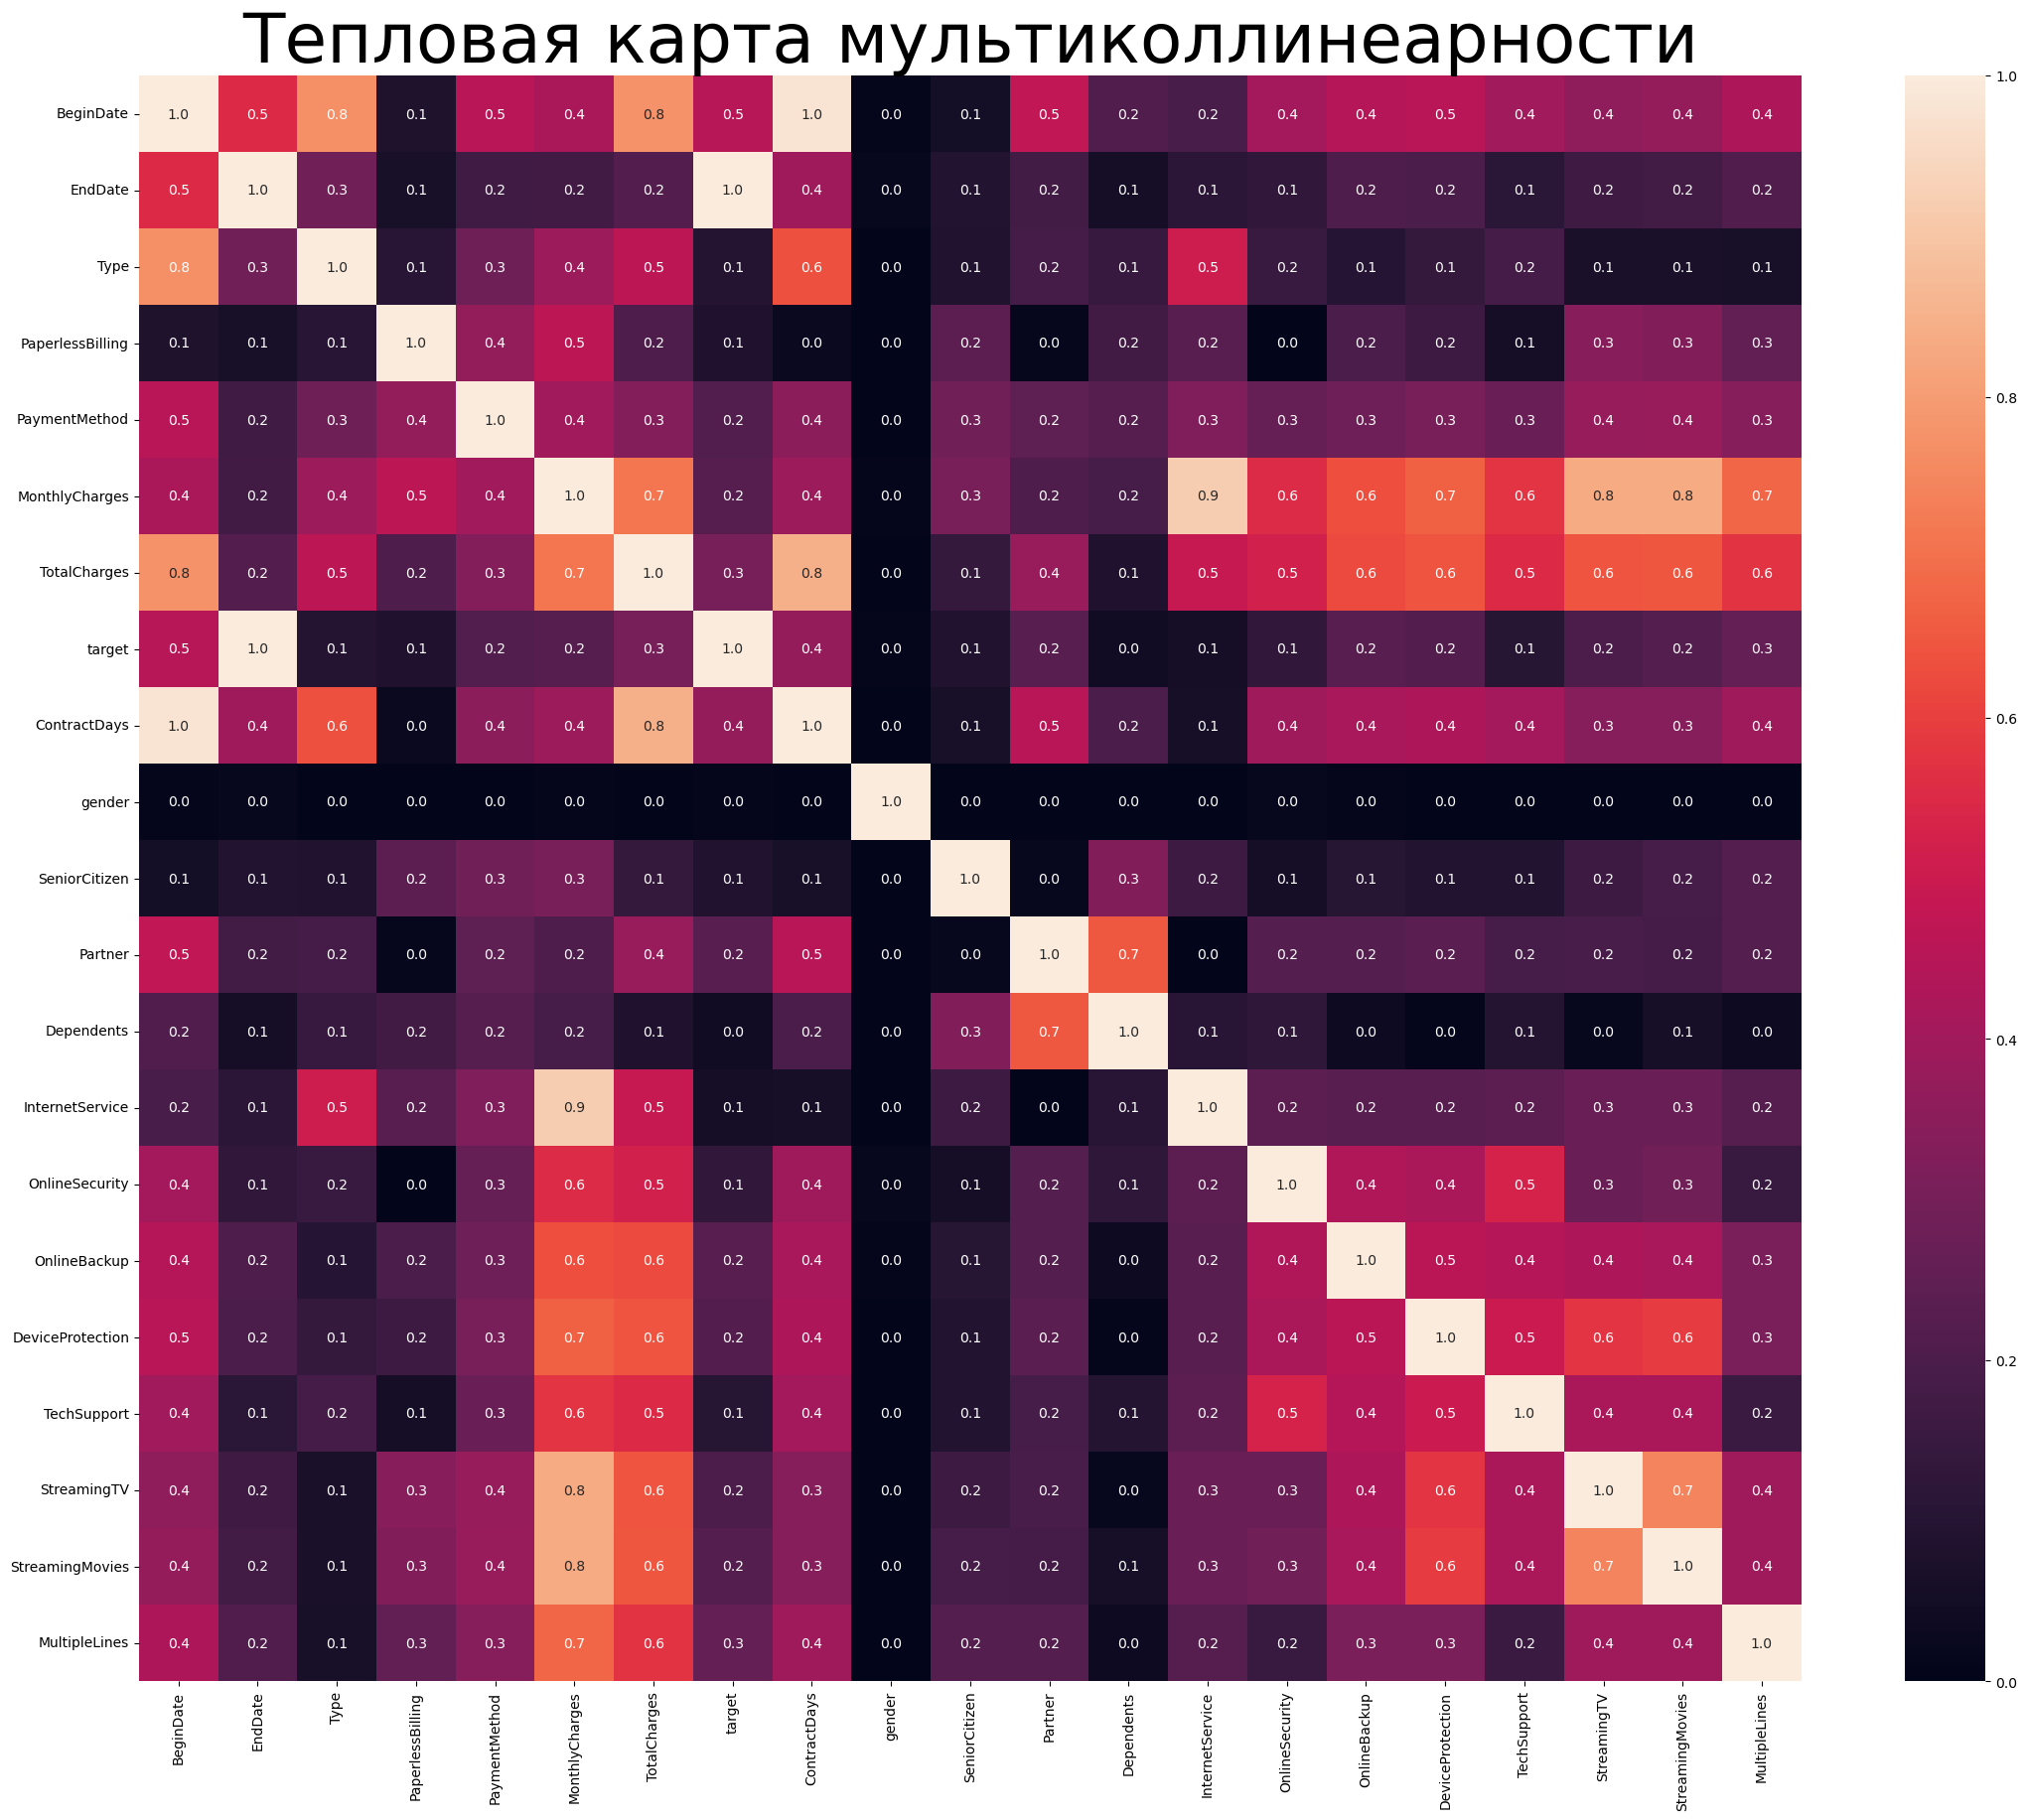

In [26]:
plt.figure(figsize=(27,21))
sns.heatmap(data.phik_matrix(), annot=True, fmt='.1f')
plt.title('Тепловая карта мультиколлинеарности', fontsize =50);

**На тепловой карте бросается в глаза блок интернет услуг. Эти признаки высоко коррелируют как между собой, так и со столбцом ежемесячной оплаты и общей оплаты.  
У признака gender нулевая корреляция со всеми признаками в том числе и целевым признаком. 
EndDate есть зеркальное отражение целевой переменной, если оставить признак - модель будет учиться только по нему. BeginDate коррелирует с ContractDays.**

**Рассмотрим паттерны клиентов, которые расторгли договор.**

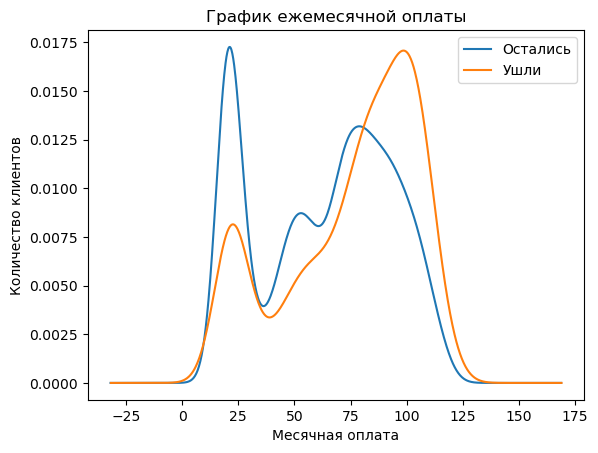

In [27]:
data.groupby('target')['MonthlyCharges'].plot(kind='density')
plt.title('График ежемесячной оплаты')
plt.legend(['Остались', 'Ушли'])
plt.xlabel('Месячная оплата')
plt.ylabel('Количество клиентов')
plt.show()

**На графике есть выраженный пик по завышенным месячным оплатам у ушедших клиентов по сравнению с  оставшимся.**

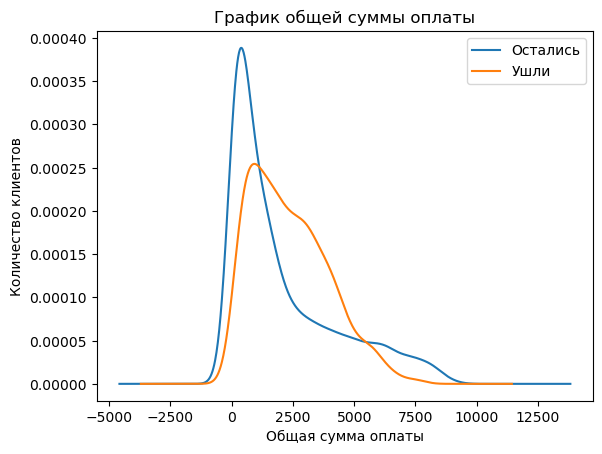

In [28]:
data.groupby('target')['TotalCharges'].plot(kind='density')
plt.title('График общей суммы оплаты')
plt.legend(['Остались', 'Ушли'])
plt.xlabel('Общая сумма оплаты')
plt.ylabel('Количество клиентов')
plt.show()

**На графике общей суммы оплаты у ушедших пользователей выдна склонность к переплате.**

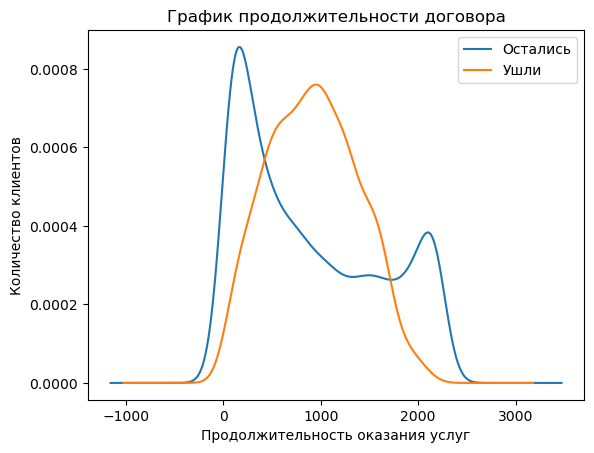

In [29]:
data.groupby('target')['ContractDays'].plot(kind='density')
plt.title('График продолжительности договора')
plt.legend(['Остались', 'Ушли'])
plt.xlabel('Продолжительность оказания услуг')
plt.ylabel('Количество клиентов')
plt.show()

**Клиенты прошедшие 500 дневный рубеж склонны расторгать договор с компанией.**

In [30]:
data.groupby('target').median()

,MonthlyCharges,TotalCharges,ContractDays,SeniorCitizen
target,,,,
0.0,69.2,1192.80,702.0,0.0
1.0,84.2,2139.03,915.0,0.0


**Если посмотреть на графики выше и на медианные значения ежемесячных оплат, то можно заметить, что ушедшие клиенты платили больше, чем оставшееся клиенты. По общим суммарным затратам ушедший пользователь превосходит оставшегося в два раза. При этом, перед уходом пользователь склонен задерживаться и продолжать пользоваться услугами ещё какое-то время.  
Если пользователи с не охотой расторгают договор - можно предположить, что качество услуг устраивает. Не устраивает завышенная оплата за услуги. Можно рекомендовать ввести систему персональных скидок для клиентов, которые продолжают пользоваться услугами 500 дней и более.**

## Обучение и проверка моделей

**Подготавливаем выборки - делим, кодируем, стандартизируем**

In [31]:
# удаляем лишние признаки и формируем целевой признак
features = data.drop(['target', 'BeginDate','EndDate', 'gender'], axis=1)
target = data['target']

In [32]:
# делим датасет на тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, stratify=target, random_state=RANDOM_STATE)

In [33]:
# список категориальных признаков для OHE
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [34]:
# Список числительных признаков для SS. Исключаем признак SeniorCitizen, так как он бинарный категориальный.
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('SeniorCitizen')
num_features

['MonthlyCharges', 'TotalCharges', 'ContractDays']

In [35]:
# макет трансформера для признаков
col_transformer = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_features),
    (StandardScaler(), num_features),
    remainder='passthrough',
    verbose_feature_names_out=False
)

**Модель Логистическая Регрессия**

In [36]:
model_lr = LogisticRegression(solver='saga', max_iter=10, random_state=RANDOM_STATE)

In [37]:
pipeline_lr = make_pipeline(col_transformer, model_lr)

In [38]:
parameters_lr = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'logisticregression__class_weight': ['None', 'balanced'],
                'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'None'],
                'logisticregression__l1_ratio': [0.25, 0.5, 0.75]
}

In [39]:
grid_lr = GridSearchCV(pipeline_lr, parameters_lr, scoring='roc_auc', cv=5, n_jobs=-1)

In [40]:
%%time
grid_lr.fit(features_train, target_train)

Wall time: 12.9 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'InternetService',


In [41]:
grid_lr_best_params = grid_lr.best_params_

In [42]:
grid_lr_best_score = grid_lr.best_score_

In [43]:
accuracy_train_lr = cross_val_score(grid_lr.best_estimator_, features_train, target_train, scoring='accuracy', cv=5).mean()

In [44]:
grid_lr_best_params

{'logisticregression__C': 10,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__l1_ratio': 0.25,
 'logisticregression__penalty': 'elasticnet'}

In [45]:
grid_lr_best_score

0.7747170647549387

In [46]:
accuracy_train_lr

0.7122333792035779

**Модель Случайный Лес**

In [47]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

In [48]:
pipeline_rf = make_pipeline(col_transformer, model_rf)

In [49]:
parameters_rf = {
    'randomforestclassifier__n_estimators': range(50, 501, 50),
    'randomforestclassifier__max_depth': range(2, 11),
    'randomforestclassifier__min_samples_split': [2, 3, 4],
    'randomforestclassifier__min_samples_leaf': [1, 2, 3, 4],
    'randomforestclassifier__class_weight': ['None', 'balanced', 'balanced_subsample']
    }

In [50]:
grid_rf = RandomizedSearchCV(pipeline_rf, parameters_rf, scoring='roc_auc', cv=5, n_jobs=-1)

In [51]:
%%time
grid_rf.fit(features_train, target_train)

Wall time: 10.6 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'Partner',
                                                                                'Dependents',
                           

In [52]:
grid_rf_best_params = grid_rf.best_params_

In [53]:
grid_rf_best_score = grid_rf.best_score_

In [54]:
accuracy_train_rf = cross_val_score(grid_rf.best_estimator_, features_train, target_train, scoring='accuracy', cv=5).mean()

In [55]:
grid_rf_best_params

{'randomforestclassifier__n_estimators': 400,
 'randomforestclassifier__min_samples_split': 4,
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__class_weight': 'balanced'}

In [56]:
grid_rf_best_score

0.8315213385336631

In [57]:
accuracy_train_rf

0.8089751583956882

**Модель CatBoost**

In [58]:
model_cat = CatBoostClassifier(random_state=RANDOM_STATE)

In [59]:
pipeline_cat = make_pipeline(col_transformer, model_cat)

In [60]:
parameters_cat = {'catboostclassifier__depth': range(2, 11),
                  'catboostclassifier__learning_rate': [0.1, 0.3, 0.5],
                  'catboostclassifier__auto_class_weights': ['None', 'balanced']
                 }

In [61]:
grid_cat = GridSearchCV(pipeline_cat, parameters_cat, scoring='roc_auc', cv=5, n_jobs=-1, verbose=False)

In [62]:
%%time
grid_cat.fit(features_train, target_train)

0:	learn: 0.5381560	total: 145ms	remaining: 2m 24s
1:	learn: 0.4499056	total: 147ms	remaining: 1m 13s
2:	learn: 0.4178469	total: 149ms	remaining: 49.6s
3:	learn: 0.3968495	total: 151ms	remaining: 37.7s
4:	learn: 0.3768171	total: 153ms	remaining: 30.5s
5:	learn: 0.3697685	total: 155ms	remaining: 25.7s
6:	learn: 0.3635850	total: 157ms	remaining: 22.3s
7:	learn: 0.3573868	total: 159ms	remaining: 19.7s
8:	learn: 0.3533095	total: 161ms	remaining: 17.7s
9:	learn: 0.3476966	total: 163ms	remaining: 16.1s
10:	learn: 0.3430744	total: 165ms	remaining: 14.8s
11:	learn: 0.3400697	total: 167ms	remaining: 13.7s
12:	learn: 0.3365798	total: 169ms	remaining: 12.8s
13:	learn: 0.3351090	total: 171ms	remaining: 12s
14:	learn: 0.3322102	total: 173ms	remaining: 11.3s
15:	learn: 0.3304534	total: 174ms	remaining: 10.7s
16:	learn: 0.3292173	total: 176ms	remaining: 10.2s
17:	learn: 0.3274568	total: 178ms	remaining: 9.72s
18:	learn: 0.3256035	total: 180ms	remaining: 9.29s
19:	learn: 0.3249743	total: 182ms	remaini

202:	learn: 0.2052857	total: 546ms	remaining: 2.14s
203:	learn: 0.2045064	total: 548ms	remaining: 2.14s
204:	learn: 0.2043875	total: 550ms	remaining: 2.13s
205:	learn: 0.2042043	total: 552ms	remaining: 2.13s
206:	learn: 0.2041544	total: 554ms	remaining: 2.12s
207:	learn: 0.2037373	total: 556ms	remaining: 2.12s
208:	learn: 0.2036461	total: 558ms	remaining: 2.11s
209:	learn: 0.2035067	total: 560ms	remaining: 2.11s
210:	learn: 0.2034119	total: 563ms	remaining: 2.1s
211:	learn: 0.2033091	total: 565ms	remaining: 2.1s
212:	learn: 0.2022226	total: 567ms	remaining: 2.09s
213:	learn: 0.2021629	total: 569ms	remaining: 2.09s
214:	learn: 0.2020347	total: 571ms	remaining: 2.08s
215:	learn: 0.2017982	total: 573ms	remaining: 2.08s
216:	learn: 0.2016067	total: 575ms	remaining: 2.08s
217:	learn: 0.2014659	total: 577ms	remaining: 2.07s
218:	learn: 0.2014060	total: 579ms	remaining: 2.06s
219:	learn: 0.2002447	total: 581ms	remaining: 2.06s
220:	learn: 0.1994500	total: 584ms	remaining: 2.06s
221:	learn: 0.

393:	learn: 0.1553903	total: 941ms	remaining: 1.45s
394:	learn: 0.1552022	total: 944ms	remaining: 1.45s
395:	learn: 0.1547922	total: 946ms	remaining: 1.44s
396:	learn: 0.1547129	total: 948ms	remaining: 1.44s
397:	learn: 0.1543095	total: 950ms	remaining: 1.44s
398:	learn: 0.1542018	total: 952ms	remaining: 1.43s
399:	learn: 0.1541175	total: 954ms	remaining: 1.43s
400:	learn: 0.1534981	total: 956ms	remaining: 1.43s
401:	learn: 0.1533919	total: 958ms	remaining: 1.43s
402:	learn: 0.1531252	total: 960ms	remaining: 1.42s
403:	learn: 0.1529840	total: 963ms	remaining: 1.42s
404:	learn: 0.1527307	total: 965ms	remaining: 1.42s
405:	learn: 0.1526246	total: 967ms	remaining: 1.41s
406:	learn: 0.1525412	total: 969ms	remaining: 1.41s
407:	learn: 0.1524457	total: 971ms	remaining: 1.41s
408:	learn: 0.1524380	total: 973ms	remaining: 1.41s
409:	learn: 0.1523202	total: 975ms	remaining: 1.4s
410:	learn: 0.1522172	total: 977ms	remaining: 1.4s
411:	learn: 0.1519843	total: 979ms	remaining: 1.4s
412:	learn: 0.1

591:	learn: 0.1324551	total: 1.34s	remaining: 924ms
592:	learn: 0.1324521	total: 1.34s	remaining: 922ms
593:	learn: 0.1324495	total: 1.34s	remaining: 919ms
594:	learn: 0.1324371	total: 1.35s	remaining: 917ms
595:	learn: 0.1323895	total: 1.35s	remaining: 915ms
596:	learn: 0.1323199	total: 1.35s	remaining: 912ms
597:	learn: 0.1322191	total: 1.35s	remaining: 910ms
598:	learn: 0.1321638	total: 1.35s	remaining: 907ms
599:	learn: 0.1321085	total: 1.36s	remaining: 905ms
600:	learn: 0.1320490	total: 1.36s	remaining: 903ms
601:	learn: 0.1319148	total: 1.36s	remaining: 900ms
602:	learn: 0.1318553	total: 1.36s	remaining: 898ms
603:	learn: 0.1318159	total: 1.36s	remaining: 895ms
604:	learn: 0.1317167	total: 1.37s	remaining: 893ms
605:	learn: 0.1314674	total: 1.37s	remaining: 890ms
606:	learn: 0.1314356	total: 1.37s	remaining: 888ms
607:	learn: 0.1312847	total: 1.37s	remaining: 885ms
608:	learn: 0.1312072	total: 1.38s	remaining: 883ms
609:	learn: 0.1311519	total: 1.38s	remaining: 881ms
610:	learn: 

793:	learn: 0.1182203	total: 1.74s	remaining: 452ms
794:	learn: 0.1182123	total: 1.74s	remaining: 450ms
795:	learn: 0.1180289	total: 1.75s	remaining: 447ms
796:	learn: 0.1179691	total: 1.75s	remaining: 445ms
797:	learn: 0.1179129	total: 1.75s	remaining: 443ms
798:	learn: 0.1177287	total: 1.75s	remaining: 441ms
799:	learn: 0.1176862	total: 1.75s	remaining: 438ms
800:	learn: 0.1176647	total: 1.75s	remaining: 436ms
801:	learn: 0.1176195	total: 1.76s	remaining: 434ms
802:	learn: 0.1175959	total: 1.76s	remaining: 432ms
803:	learn: 0.1175653	total: 1.76s	remaining: 429ms
804:	learn: 0.1174829	total: 1.76s	remaining: 427ms
805:	learn: 0.1173169	total: 1.76s	remaining: 425ms
806:	learn: 0.1172626	total: 1.77s	remaining: 423ms
807:	learn: 0.1170230	total: 1.77s	remaining: 420ms
808:	learn: 0.1169810	total: 1.77s	remaining: 418ms
809:	learn: 0.1169284	total: 1.77s	remaining: 416ms
810:	learn: 0.1168703	total: 1.77s	remaining: 414ms
811:	learn: 0.1167263	total: 1.78s	remaining: 411ms
812:	learn: 

999:	learn: 0.1060119	total: 2.14s	remaining: 0us
Wall time: 7min 49s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'InternetService',


In [63]:
grid_cat_best_params = grid_cat.best_params_

In [64]:
grid_cat_best_score = grid_cat.best_score_

In [65]:
accuracy_train_cat = cross_val_score(grid_cat.best_estimator_, features_train, target_train, scoring='accuracy', cv=5).mean()

0:	learn: 0.5384001	total: 1.8ms	remaining: 1.8s
1:	learn: 0.4477168	total: 3.96ms	remaining: 1.97s
2:	learn: 0.4115652	total: 5.78ms	remaining: 1.92s
3:	learn: 0.3955096	total: 7.55ms	remaining: 1.88s
4:	learn: 0.3766995	total: 9.32ms	remaining: 1.85s
5:	learn: 0.3707011	total: 11ms	remaining: 1.83s
6:	learn: 0.3615292	total: 12.8ms	remaining: 1.81s
7:	learn: 0.3558089	total: 14.6ms	remaining: 1.82s
8:	learn: 0.3505468	total: 16.6ms	remaining: 1.82s
9:	learn: 0.3474568	total: 18.4ms	remaining: 1.82s
10:	learn: 0.3443141	total: 20.2ms	remaining: 1.81s
11:	learn: 0.3412319	total: 21.9ms	remaining: 1.8s
12:	learn: 0.3391309	total: 23.7ms	remaining: 1.8s
13:	learn: 0.3356784	total: 25.5ms	remaining: 1.79s
14:	learn: 0.3334408	total: 27.2ms	remaining: 1.79s
15:	learn: 0.3315229	total: 28.9ms	remaining: 1.78s
16:	learn: 0.3308102	total: 30.6ms	remaining: 1.77s
17:	learn: 0.3294909	total: 32.3ms	remaining: 1.76s
18:	learn: 0.3285158	total: 34ms	remaining: 1.76s
19:	learn: 0.3252574	total: 36

208:	learn: 0.1964000	total: 383ms	remaining: 1.45s
209:	learn: 0.1958383	total: 386ms	remaining: 1.45s
210:	learn: 0.1956774	total: 387ms	remaining: 1.45s
211:	learn: 0.1952919	total: 389ms	remaining: 1.45s
212:	learn: 0.1948956	total: 391ms	remaining: 1.45s
213:	learn: 0.1948067	total: 393ms	remaining: 1.44s
214:	learn: 0.1946126	total: 395ms	remaining: 1.44s
215:	learn: 0.1941912	total: 397ms	remaining: 1.44s
216:	learn: 0.1939908	total: 399ms	remaining: 1.44s
217:	learn: 0.1938928	total: 400ms	remaining: 1.44s
218:	learn: 0.1932998	total: 402ms	remaining: 1.43s
219:	learn: 0.1924164	total: 404ms	remaining: 1.43s
220:	learn: 0.1923023	total: 406ms	remaining: 1.43s
221:	learn: 0.1921153	total: 408ms	remaining: 1.43s
222:	learn: 0.1913775	total: 410ms	remaining: 1.43s
223:	learn: 0.1912578	total: 412ms	remaining: 1.43s
224:	learn: 0.1910692	total: 413ms	remaining: 1.42s
225:	learn: 0.1896655	total: 415ms	remaining: 1.42s
226:	learn: 0.1894728	total: 417ms	remaining: 1.42s
227:	learn: 

423:	learn: 0.1448820	total: 783ms	remaining: 1.06s
424:	learn: 0.1447352	total: 785ms	remaining: 1.06s
425:	learn: 0.1446189	total: 787ms	remaining: 1.06s
426:	learn: 0.1445739	total: 789ms	remaining: 1.06s
427:	learn: 0.1444374	total: 791ms	remaining: 1.06s
428:	learn: 0.1443334	total: 793ms	remaining: 1.05s
429:	learn: 0.1440810	total: 794ms	remaining: 1.05s
430:	learn: 0.1440084	total: 796ms	remaining: 1.05s
431:	learn: 0.1435452	total: 798ms	remaining: 1.05s
432:	learn: 0.1434375	total: 800ms	remaining: 1.05s
433:	learn: 0.1433737	total: 802ms	remaining: 1.04s
434:	learn: 0.1432308	total: 804ms	remaining: 1.04s
435:	learn: 0.1431373	total: 805ms	remaining: 1.04s
436:	learn: 0.1430275	total: 807ms	remaining: 1.04s
437:	learn: 0.1428891	total: 809ms	remaining: 1.04s
438:	learn: 0.1427858	total: 811ms	remaining: 1.04s
439:	learn: 0.1426760	total: 813ms	remaining: 1.03s
440:	learn: 0.1426257	total: 814ms	remaining: 1.03s
441:	learn: 0.1426202	total: 816ms	remaining: 1.03s
442:	learn: 

647:	learn: 0.1183588	total: 1.18s	remaining: 641ms
648:	learn: 0.1180072	total: 1.18s	remaining: 640ms
649:	learn: 0.1177119	total: 1.18s	remaining: 638ms
650:	learn: 0.1176190	total: 1.19s	remaining: 636ms
651:	learn: 0.1174894	total: 1.19s	remaining: 634ms
652:	learn: 0.1174320	total: 1.19s	remaining: 632ms
653:	learn: 0.1173703	total: 1.19s	remaining: 630ms
654:	learn: 0.1173325	total: 1.19s	remaining: 629ms
655:	learn: 0.1172438	total: 1.2s	remaining: 627ms
656:	learn: 0.1170961	total: 1.2s	remaining: 625ms
657:	learn: 0.1170299	total: 1.2s	remaining: 623ms
658:	learn: 0.1169310	total: 1.2s	remaining: 621ms
659:	learn: 0.1168920	total: 1.2s	remaining: 619ms
660:	learn: 0.1167992	total: 1.2s	remaining: 617ms
661:	learn: 0.1167643	total: 1.21s	remaining: 615ms
662:	learn: 0.1167299	total: 1.21s	remaining: 614ms
663:	learn: 0.1166571	total: 1.21s	remaining: 612ms
664:	learn: 0.1166068	total: 1.21s	remaining: 610ms
665:	learn: 0.1165639	total: 1.21s	remaining: 608ms
666:	learn: 0.1165

874:	learn: 0.1010004	total: 1.58s	remaining: 225ms
875:	learn: 0.1009000	total: 1.58s	remaining: 224ms
876:	learn: 0.1008329	total: 1.58s	remaining: 222ms
877:	learn: 0.1007915	total: 1.58s	remaining: 220ms
878:	learn: 0.1007890	total: 1.58s	remaining: 218ms
879:	learn: 0.1007841	total: 1.59s	remaining: 216ms
880:	learn: 0.1007322	total: 1.59s	remaining: 214ms
881:	learn: 0.1006899	total: 1.59s	remaining: 213ms
882:	learn: 0.1006332	total: 1.59s	remaining: 211ms
883:	learn: 0.1005894	total: 1.59s	remaining: 209ms
884:	learn: 0.1005400	total: 1.59s	remaining: 207ms
885:	learn: 0.1003612	total: 1.6s	remaining: 205ms
886:	learn: 0.1002452	total: 1.6s	remaining: 204ms
887:	learn: 0.1002134	total: 1.6s	remaining: 202ms
888:	learn: 0.1001018	total: 1.6s	remaining: 200ms
889:	learn: 0.1000472	total: 1.6s	remaining: 198ms
890:	learn: 0.0999534	total: 1.6s	remaining: 196ms
891:	learn: 0.0998580	total: 1.61s	remaining: 195ms
892:	learn: 0.0997833	total: 1.61s	remaining: 193ms
893:	learn: 0.0997

40:	learn: 0.3153539	total: 67.4ms	remaining: 1.58s
41:	learn: 0.3145090	total: 69.1ms	remaining: 1.58s
42:	learn: 0.3140608	total: 70.8ms	remaining: 1.58s
43:	learn: 0.3136320	total: 72.5ms	remaining: 1.57s
44:	learn: 0.3133320	total: 74ms	remaining: 1.57s
45:	learn: 0.3129568	total: 75.7ms	remaining: 1.57s
46:	learn: 0.3126453	total: 77.4ms	remaining: 1.57s
47:	learn: 0.3118327	total: 78.9ms	remaining: 1.56s
48:	learn: 0.3115452	total: 80.7ms	remaining: 1.57s
49:	learn: 0.3111789	total: 82.2ms	remaining: 1.56s
50:	learn: 0.3094798	total: 84ms	remaining: 1.56s
51:	learn: 0.3092058	total: 85.6ms	remaining: 1.56s
52:	learn: 0.3089115	total: 87.1ms	remaining: 1.56s
53:	learn: 0.3085703	total: 88.8ms	remaining: 1.55s
54:	learn: 0.3082649	total: 90.4ms	remaining: 1.55s
55:	learn: 0.3079649	total: 91.9ms	remaining: 1.55s
56:	learn: 0.3067963	total: 93.6ms	remaining: 1.55s
57:	learn: 0.3064130	total: 95.2ms	remaining: 1.55s
58:	learn: 0.3060756	total: 96.8ms	remaining: 1.54s
59:	learn: 0.305

238:	learn: 0.1950655	total: 406ms	remaining: 1.29s
239:	learn: 0.1946203	total: 408ms	remaining: 1.29s
240:	learn: 0.1945328	total: 409ms	remaining: 1.29s
241:	learn: 0.1945151	total: 411ms	remaining: 1.29s
242:	learn: 0.1944629	total: 413ms	remaining: 1.29s
243:	learn: 0.1942890	total: 414ms	remaining: 1.28s
244:	learn: 0.1940575	total: 416ms	remaining: 1.28s
245:	learn: 0.1938455	total: 418ms	remaining: 1.28s
246:	learn: 0.1935192	total: 420ms	remaining: 1.28s
247:	learn: 0.1932183	total: 421ms	remaining: 1.28s
248:	learn: 0.1930651	total: 423ms	remaining: 1.28s
249:	learn: 0.1928836	total: 425ms	remaining: 1.27s
250:	learn: 0.1925060	total: 427ms	remaining: 1.27s
251:	learn: 0.1920607	total: 428ms	remaining: 1.27s
252:	learn: 0.1917941	total: 430ms	remaining: 1.27s
253:	learn: 0.1916303	total: 432ms	remaining: 1.27s
254:	learn: 0.1914569	total: 434ms	remaining: 1.27s
255:	learn: 0.1906961	total: 435ms	remaining: 1.26s
256:	learn: 0.1903228	total: 437ms	remaining: 1.26s
257:	learn: 

464:	learn: 0.1509985	total: 800ms	remaining: 920ms
465:	learn: 0.1508749	total: 802ms	remaining: 919ms
466:	learn: 0.1507513	total: 804ms	remaining: 917ms
467:	learn: 0.1506511	total: 805ms	remaining: 915ms
468:	learn: 0.1505223	total: 807ms	remaining: 914ms
469:	learn: 0.1504297	total: 809ms	remaining: 912ms
470:	learn: 0.1503880	total: 811ms	remaining: 910ms
471:	learn: 0.1501331	total: 812ms	remaining: 909ms
472:	learn: 0.1500628	total: 814ms	remaining: 907ms
473:	learn: 0.1497834	total: 816ms	remaining: 906ms
474:	learn: 0.1496761	total: 818ms	remaining: 904ms
475:	learn: 0.1494288	total: 820ms	remaining: 902ms
476:	learn: 0.1493699	total: 821ms	remaining: 900ms
477:	learn: 0.1493655	total: 823ms	remaining: 899ms
478:	learn: 0.1492970	total: 825ms	remaining: 897ms
479:	learn: 0.1492863	total: 827ms	remaining: 895ms
480:	learn: 0.1492662	total: 828ms	remaining: 894ms
481:	learn: 0.1491530	total: 830ms	remaining: 892ms
482:	learn: 0.1490764	total: 832ms	remaining: 890ms
483:	learn: 

689:	learn: 0.1263651	total: 1.2s	remaining: 539ms
690:	learn: 0.1262785	total: 1.2s	remaining: 538ms
691:	learn: 0.1261789	total: 1.2s	remaining: 536ms
692:	learn: 0.1260778	total: 1.21s	remaining: 534ms
693:	learn: 0.1260325	total: 1.21s	remaining: 532ms
694:	learn: 0.1260073	total: 1.21s	remaining: 531ms
695:	learn: 0.1259395	total: 1.21s	remaining: 529ms
696:	learn: 0.1259129	total: 1.21s	remaining: 527ms
697:	learn: 0.1258470	total: 1.21s	remaining: 525ms
698:	learn: 0.1258170	total: 1.22s	remaining: 524ms
699:	learn: 0.1257583	total: 1.22s	remaining: 522ms
700:	learn: 0.1256956	total: 1.22s	remaining: 520ms
701:	learn: 0.1256375	total: 1.22s	remaining: 519ms
702:	learn: 0.1255239	total: 1.22s	remaining: 517ms
703:	learn: 0.1254919	total: 1.23s	remaining: 515ms
704:	learn: 0.1254430	total: 1.23s	remaining: 513ms
705:	learn: 0.1253890	total: 1.23s	remaining: 512ms
706:	learn: 0.1253380	total: 1.23s	remaining: 510ms
707:	learn: 0.1252400	total: 1.23s	remaining: 508ms
708:	learn: 0.1

916:	learn: 0.1112406	total: 1.6s	remaining: 145ms
917:	learn: 0.1111707	total: 1.6s	remaining: 143ms
918:	learn: 0.1111149	total: 1.6s	remaining: 141ms
919:	learn: 0.1110365	total: 1.6s	remaining: 139ms
920:	learn: 0.1109636	total: 1.6s	remaining: 138ms
921:	learn: 0.1109620	total: 1.61s	remaining: 136ms
922:	learn: 0.1109219	total: 1.61s	remaining: 134ms
923:	learn: 0.1108759	total: 1.61s	remaining: 132ms
924:	learn: 0.1108366	total: 1.61s	remaining: 131ms
925:	learn: 0.1107626	total: 1.61s	remaining: 129ms
926:	learn: 0.1107284	total: 1.61s	remaining: 127ms
927:	learn: 0.1105703	total: 1.62s	remaining: 125ms
928:	learn: 0.1104950	total: 1.62s	remaining: 124ms
929:	learn: 0.1103619	total: 1.62s	remaining: 122ms
930:	learn: 0.1103340	total: 1.62s	remaining: 120ms
931:	learn: 0.1102782	total: 1.62s	remaining: 118ms
932:	learn: 0.1101976	total: 1.63s	remaining: 117ms
933:	learn: 0.1101142	total: 1.63s	remaining: 115ms
934:	learn: 0.1100775	total: 1.63s	remaining: 113ms
935:	learn: 0.110

118:	learn: 0.2395245	total: 205ms	remaining: 1.51s
119:	learn: 0.2392693	total: 207ms	remaining: 1.51s
120:	learn: 0.2391326	total: 208ms	remaining: 1.51s
121:	learn: 0.2385910	total: 210ms	remaining: 1.51s
122:	learn: 0.2384736	total: 212ms	remaining: 1.51s
123:	learn: 0.2382746	total: 214ms	remaining: 1.51s
124:	learn: 0.2371692	total: 216ms	remaining: 1.51s
125:	learn: 0.2370618	total: 217ms	remaining: 1.51s
126:	learn: 0.2369291	total: 219ms	remaining: 1.5s
127:	learn: 0.2368035	total: 220ms	remaining: 1.5s
128:	learn: 0.2367312	total: 222ms	remaining: 1.5s
129:	learn: 0.2349372	total: 224ms	remaining: 1.5s
130:	learn: 0.2346924	total: 226ms	remaining: 1.5s
131:	learn: 0.2345513	total: 227ms	remaining: 1.49s
132:	learn: 0.2339322	total: 229ms	remaining: 1.49s
133:	learn: 0.2332261	total: 231ms	remaining: 1.49s
134:	learn: 0.2321331	total: 233ms	remaining: 1.49s
135:	learn: 0.2318651	total: 234ms	remaining: 1.49s
136:	learn: 0.2317304	total: 236ms	remaining: 1.49s
137:	learn: 0.231

344:	learn: 0.1540304	total: 600ms	remaining: 1.14s
345:	learn: 0.1537420	total: 602ms	remaining: 1.14s
346:	learn: 0.1535422	total: 604ms	remaining: 1.14s
347:	learn: 0.1534153	total: 606ms	remaining: 1.13s
348:	learn: 0.1533236	total: 607ms	remaining: 1.13s
349:	learn: 0.1532340	total: 609ms	remaining: 1.13s
350:	learn: 0.1531614	total: 611ms	remaining: 1.13s
351:	learn: 0.1531185	total: 613ms	remaining: 1.13s
352:	learn: 0.1530273	total: 614ms	remaining: 1.13s
353:	learn: 0.1529370	total: 616ms	remaining: 1.12s
354:	learn: 0.1528171	total: 618ms	remaining: 1.12s
355:	learn: 0.1527002	total: 620ms	remaining: 1.12s
356:	learn: 0.1526429	total: 622ms	remaining: 1.12s
357:	learn: 0.1524764	total: 623ms	remaining: 1.12s
358:	learn: 0.1521746	total: 625ms	remaining: 1.12s
359:	learn: 0.1520863	total: 627ms	remaining: 1.11s
360:	learn: 0.1520221	total: 629ms	remaining: 1.11s
361:	learn: 0.1517366	total: 630ms	remaining: 1.11s
362:	learn: 0.1512988	total: 632ms	remaining: 1.11s
363:	learn: 

572:	learn: 0.1244844	total: 998ms	remaining: 744ms
573:	learn: 0.1244209	total: 1s	remaining: 742ms
574:	learn: 0.1243009	total: 1s	remaining: 741ms
575:	learn: 0.1241465	total: 1s	remaining: 739ms
576:	learn: 0.1240655	total: 1s	remaining: 737ms
577:	learn: 0.1239967	total: 1.01s	remaining: 736ms
578:	learn: 0.1239202	total: 1.01s	remaining: 734ms
579:	learn: 0.1237930	total: 1.01s	remaining: 732ms
580:	learn: 0.1237547	total: 1.01s	remaining: 730ms
581:	learn: 0.1237190	total: 1.01s	remaining: 728ms
582:	learn: 0.1236571	total: 1.02s	remaining: 727ms
583:	learn: 0.1235907	total: 1.02s	remaining: 725ms
584:	learn: 0.1234976	total: 1.02s	remaining: 723ms
585:	learn: 0.1233359	total: 1.02s	remaining: 722ms
586:	learn: 0.1232223	total: 1.02s	remaining: 720ms
587:	learn: 0.1231489	total: 1.02s	remaining: 718ms
588:	learn: 0.1230800	total: 1.03s	remaining: 716ms
589:	learn: 0.1230677	total: 1.03s	remaining: 715ms
590:	learn: 0.1230237	total: 1.03s	remaining: 713ms
591:	learn: 0.1229780	to

799:	learn: 0.1044823	total: 1.4s	remaining: 349ms
800:	learn: 0.1044253	total: 1.4s	remaining: 347ms
801:	learn: 0.1044022	total: 1.4s	remaining: 346ms
802:	learn: 0.1043055	total: 1.4s	remaining: 344ms
803:	learn: 0.1042560	total: 1.4s	remaining: 342ms
804:	learn: 0.1042402	total: 1.4s	remaining: 340ms
805:	learn: 0.1041907	total: 1.41s	remaining: 339ms
806:	learn: 0.1040031	total: 1.41s	remaining: 337ms
807:	learn: 0.1039458	total: 1.41s	remaining: 335ms
808:	learn: 0.1039235	total: 1.41s	remaining: 333ms
809:	learn: 0.1038861	total: 1.41s	remaining: 332ms
810:	learn: 0.1038501	total: 1.42s	remaining: 330ms
811:	learn: 0.1038041	total: 1.42s	remaining: 328ms
812:	learn: 0.1037772	total: 1.42s	remaining: 326ms
813:	learn: 0.1037344	total: 1.42s	remaining: 325ms
814:	learn: 0.1036105	total: 1.42s	remaining: 323ms
815:	learn: 0.1035765	total: 1.42s	remaining: 321ms
816:	learn: 0.1035684	total: 1.43s	remaining: 319ms
817:	learn: 0.1035154	total: 1.43s	remaining: 318ms
818:	learn: 0.1034

0:	learn: 0.5394302	total: 1.88ms	remaining: 1.88s
1:	learn: 0.4630922	total: 3.76ms	remaining: 1.87s
2:	learn: 0.4104756	total: 5.51ms	remaining: 1.83s
3:	learn: 0.3873123	total: 7.24ms	remaining: 1.8s
4:	learn: 0.3754540	total: 8.97ms	remaining: 1.78s
5:	learn: 0.3669162	total: 10.6ms	remaining: 1.76s
6:	learn: 0.3626803	total: 12.2ms	remaining: 1.73s
7:	learn: 0.3573652	total: 13.9ms	remaining: 1.73s
8:	learn: 0.3521879	total: 15.5ms	remaining: 1.71s
9:	learn: 0.3500426	total: 17.1ms	remaining: 1.69s
10:	learn: 0.3469690	total: 18.7ms	remaining: 1.68s
11:	learn: 0.3451637	total: 20.3ms	remaining: 1.67s
12:	learn: 0.3434760	total: 21.9ms	remaining: 1.66s
13:	learn: 0.3392279	total: 23.7ms	remaining: 1.67s
14:	learn: 0.3373556	total: 25.3ms	remaining: 1.66s
15:	learn: 0.3356653	total: 26.8ms	remaining: 1.65s
16:	learn: 0.3343210	total: 28.4ms	remaining: 1.64s
17:	learn: 0.3330869	total: 30ms	remaining: 1.64s
18:	learn: 0.3315011	total: 31.7ms	remaining: 1.64s
19:	learn: 0.3302121	tota

229:	learn: 0.1943129	total: 397ms	remaining: 1.33s
230:	learn: 0.1941194	total: 399ms	remaining: 1.33s
231:	learn: 0.1940876	total: 401ms	remaining: 1.33s
232:	learn: 0.1939288	total: 402ms	remaining: 1.32s
233:	learn: 0.1930660	total: 404ms	remaining: 1.32s
234:	learn: 0.1926749	total: 406ms	remaining: 1.32s
235:	learn: 0.1923595	total: 408ms	remaining: 1.32s
236:	learn: 0.1922029	total: 409ms	remaining: 1.32s
237:	learn: 0.1919721	total: 411ms	remaining: 1.32s
238:	learn: 0.1916918	total: 413ms	remaining: 1.31s
239:	learn: 0.1912082	total: 415ms	remaining: 1.31s
240:	learn: 0.1903361	total: 417ms	remaining: 1.31s
241:	learn: 0.1898674	total: 418ms	remaining: 1.31s
242:	learn: 0.1898118	total: 420ms	remaining: 1.31s
243:	learn: 0.1895624	total: 422ms	remaining: 1.31s
244:	learn: 0.1894183	total: 423ms	remaining: 1.3s
245:	learn: 0.1890335	total: 425ms	remaining: 1.3s
246:	learn: 0.1888600	total: 427ms	remaining: 1.3s
247:	learn: 0.1882702	total: 429ms	remaining: 1.3s
248:	learn: 0.18

457:	learn: 0.1494994	total: 796ms	remaining: 942ms
458:	learn: 0.1493713	total: 798ms	remaining: 941ms
459:	learn: 0.1492463	total: 800ms	remaining: 939ms
460:	learn: 0.1491904	total: 802ms	remaining: 938ms
461:	learn: 0.1491362	total: 804ms	remaining: 936ms
462:	learn: 0.1490374	total: 806ms	remaining: 934ms
463:	learn: 0.1488306	total: 807ms	remaining: 933ms
464:	learn: 0.1487662	total: 809ms	remaining: 931ms
465:	learn: 0.1486455	total: 811ms	remaining: 929ms
466:	learn: 0.1485562	total: 813ms	remaining: 928ms
467:	learn: 0.1483554	total: 815ms	remaining: 926ms
468:	learn: 0.1482796	total: 817ms	remaining: 924ms
469:	learn: 0.1482234	total: 818ms	remaining: 923ms
470:	learn: 0.1478222	total: 820ms	remaining: 921ms
471:	learn: 0.1477746	total: 822ms	remaining: 919ms
472:	learn: 0.1476790	total: 823ms	remaining: 918ms
473:	learn: 0.1475990	total: 825ms	remaining: 916ms
474:	learn: 0.1474387	total: 827ms	remaining: 914ms
475:	learn: 0.1471934	total: 829ms	remaining: 912ms
476:	learn: 

684:	learn: 0.1247251	total: 1.19s	remaining: 549ms
685:	learn: 0.1247130	total: 1.2s	remaining: 547ms
686:	learn: 0.1246686	total: 1.2s	remaining: 546ms
687:	learn: 0.1246185	total: 1.2s	remaining: 544ms
688:	learn: 0.1245243	total: 1.2s	remaining: 542ms
689:	learn: 0.1244820	total: 1.2s	remaining: 541ms
690:	learn: 0.1244155	total: 1.2s	remaining: 539ms
691:	learn: 0.1242862	total: 1.21s	remaining: 537ms
692:	learn: 0.1242816	total: 1.21s	remaining: 535ms
693:	learn: 0.1242488	total: 1.21s	remaining: 533ms
694:	learn: 0.1241710	total: 1.21s	remaining: 532ms
695:	learn: 0.1240661	total: 1.21s	remaining: 530ms
696:	learn: 0.1240086	total: 1.22s	remaining: 528ms
697:	learn: 0.1239602	total: 1.22s	remaining: 526ms
698:	learn: 0.1237275	total: 1.22s	remaining: 525ms
699:	learn: 0.1236986	total: 1.22s	remaining: 523ms
700:	learn: 0.1236319	total: 1.22s	remaining: 521ms
701:	learn: 0.1236281	total: 1.22s	remaining: 520ms
702:	learn: 0.1235938	total: 1.23s	remaining: 518ms
703:	learn: 0.1235

913:	learn: 0.1097916	total: 1.59s	remaining: 150ms
914:	learn: 0.1097893	total: 1.59s	remaining: 148ms
915:	learn: 0.1097874	total: 1.6s	remaining: 146ms
916:	learn: 0.1097118	total: 1.6s	remaining: 145ms
917:	learn: 0.1096627	total: 1.6s	remaining: 143ms
918:	learn: 0.1095691	total: 1.6s	remaining: 141ms
919:	learn: 0.1095499	total: 1.6s	remaining: 139ms
920:	learn: 0.1094640	total: 1.6s	remaining: 138ms
921:	learn: 0.1094228	total: 1.61s	remaining: 136ms
922:	learn: 0.1092494	total: 1.61s	remaining: 134ms
923:	learn: 0.1092275	total: 1.61s	remaining: 132ms
924:	learn: 0.1091765	total: 1.61s	remaining: 131ms
925:	learn: 0.1091747	total: 1.61s	remaining: 129ms
926:	learn: 0.1091421	total: 1.61s	remaining: 127ms
927:	learn: 0.1090607	total: 1.62s	remaining: 125ms
928:	learn: 0.1089997	total: 1.62s	remaining: 124ms
929:	learn: 0.1089365	total: 1.62s	remaining: 122ms
930:	learn: 0.1088570	total: 1.62s	remaining: 120ms
931:	learn: 0.1088182	total: 1.62s	remaining: 119ms
932:	learn: 0.1087

115:	learn: 0.2540150	total: 196ms	remaining: 1.49s
116:	learn: 0.2534184	total: 198ms	remaining: 1.49s
117:	learn: 0.2532362	total: 199ms	remaining: 1.49s
118:	learn: 0.2530304	total: 201ms	remaining: 1.49s
119:	learn: 0.2526459	total: 203ms	remaining: 1.49s
120:	learn: 0.2524657	total: 205ms	remaining: 1.49s
121:	learn: 0.2510369	total: 207ms	remaining: 1.49s
122:	learn: 0.2508294	total: 208ms	remaining: 1.49s
123:	learn: 0.2504549	total: 210ms	remaining: 1.48s
124:	learn: 0.2502287	total: 212ms	remaining: 1.48s
125:	learn: 0.2497387	total: 214ms	remaining: 1.48s
126:	learn: 0.2481284	total: 215ms	remaining: 1.48s
127:	learn: 0.2467478	total: 217ms	remaining: 1.48s
128:	learn: 0.2451763	total: 219ms	remaining: 1.48s
129:	learn: 0.2436610	total: 221ms	remaining: 1.48s
130:	learn: 0.2435038	total: 222ms	remaining: 1.48s
131:	learn: 0.2422603	total: 224ms	remaining: 1.47s
132:	learn: 0.2406283	total: 226ms	remaining: 1.47s
133:	learn: 0.2404492	total: 228ms	remaining: 1.47s
134:	learn: 

341:	learn: 0.1653866	total: 591ms	remaining: 1.14s
342:	learn: 0.1652928	total: 593ms	remaining: 1.14s
343:	learn: 0.1647665	total: 595ms	remaining: 1.13s
344:	learn: 0.1644844	total: 597ms	remaining: 1.13s
345:	learn: 0.1640044	total: 599ms	remaining: 1.13s
346:	learn: 0.1637442	total: 600ms	remaining: 1.13s
347:	learn: 0.1635989	total: 602ms	remaining: 1.13s
348:	learn: 0.1635446	total: 604ms	remaining: 1.13s
349:	learn: 0.1626572	total: 605ms	remaining: 1.12s
350:	learn: 0.1625944	total: 607ms	remaining: 1.12s
351:	learn: 0.1624515	total: 609ms	remaining: 1.12s
352:	learn: 0.1615755	total: 611ms	remaining: 1.12s
353:	learn: 0.1614034	total: 612ms	remaining: 1.12s
354:	learn: 0.1612607	total: 614ms	remaining: 1.11s
355:	learn: 0.1611023	total: 616ms	remaining: 1.11s
356:	learn: 0.1610029	total: 618ms	remaining: 1.11s
357:	learn: 0.1608621	total: 619ms	remaining: 1.11s
358:	learn: 0.1603931	total: 621ms	remaining: 1.11s
359:	learn: 0.1602995	total: 623ms	remaining: 1.11s
360:	learn: 

571:	learn: 0.1278773	total: 991ms	remaining: 741ms
572:	learn: 0.1277523	total: 993ms	remaining: 740ms
573:	learn: 0.1277117	total: 995ms	remaining: 738ms
574:	learn: 0.1276712	total: 996ms	remaining: 736ms
575:	learn: 0.1274761	total: 998ms	remaining: 735ms
576:	learn: 0.1274343	total: 1000ms	remaining: 733ms
577:	learn: 0.1272181	total: 1s	remaining: 731ms
578:	learn: 0.1271256	total: 1s	remaining: 730ms
579:	learn: 0.1270847	total: 1s	remaining: 728ms
580:	learn: 0.1270360	total: 1.01s	remaining: 726ms
581:	learn: 0.1269436	total: 1.01s	remaining: 724ms
582:	learn: 0.1268755	total: 1.01s	remaining: 723ms
583:	learn: 0.1268161	total: 1.01s	remaining: 721ms
584:	learn: 0.1268074	total: 1.01s	remaining: 719ms
585:	learn: 0.1267428	total: 1.01s	remaining: 717ms
586:	learn: 0.1265824	total: 1.02s	remaining: 716ms
587:	learn: 0.1265757	total: 1.02s	remaining: 714ms
588:	learn: 0.1265198	total: 1.02s	remaining: 712ms
589:	learn: 0.1263198	total: 1.02s	remaining: 711ms
590:	learn: 0.126196

799:	learn: 0.1098376	total: 1.39s	remaining: 347ms
800:	learn: 0.1098156	total: 1.39s	remaining: 345ms
801:	learn: 0.1097544	total: 1.39s	remaining: 343ms
802:	learn: 0.1096918	total: 1.39s	remaining: 342ms
803:	learn: 0.1095960	total: 1.39s	remaining: 340ms
804:	learn: 0.1095670	total: 1.4s	remaining: 338ms
805:	learn: 0.1095195	total: 1.4s	remaining: 336ms
806:	learn: 0.1094510	total: 1.4s	remaining: 335ms
807:	learn: 0.1093251	total: 1.4s	remaining: 333ms
808:	learn: 0.1092810	total: 1.4s	remaining: 331ms
809:	learn: 0.1092532	total: 1.4s	remaining: 329ms
810:	learn: 0.1091865	total: 1.41s	remaining: 328ms
811:	learn: 0.1091552	total: 1.41s	remaining: 326ms
812:	learn: 0.1091169	total: 1.41s	remaining: 324ms
813:	learn: 0.1090787	total: 1.41s	remaining: 323ms
814:	learn: 0.1090293	total: 1.41s	remaining: 321ms
815:	learn: 0.1089842	total: 1.41s	remaining: 319ms
816:	learn: 0.1088943	total: 1.42s	remaining: 317ms
817:	learn: 0.1088625	total: 1.42s	remaining: 316ms
818:	learn: 0.1087

In [66]:
grid_cat_best_params

{'catboostclassifier__auto_class_weights': 'None',
 'catboostclassifier__depth': 2,
 'catboostclassifier__learning_rate': 0.3}

In [67]:
grid_cat_best_score

0.9348926470336147

In [68]:
accuracy_train_cat

0.936197356727158

**Сравнение моделей**

In [69]:
result = pd.DataFrame(
                      {'time': ['13.3 s', '10.7 s', '8min 14s'],
                       'accuracy': [accuracy_train_lr, accuracy_train_rf, accuracy_train_cat],
                       'roc_auc': [grid_lr_best_score, grid_rf_best_score, grid_cat_best_score]
                       }, 
                      index=['Logistic Regression', 'Random Forest Regressor', 'CatBoost'], 
                      )
result

,time,accuracy,roc_auc
Logistic Regression,13.3 s,0.712233,0.774717
Random Forest Regressor,10.7 s,0.808975,0.831521
CatBoost,8min 14s,0.936197,0.934893


**По основной метрике roc_auc лидирует модель CatBoost. Так же эта модель лидер по метрике accuracy. Хоть для её обучения и тратится больше времени по сравнению с остальными моделями - берём эту модель на тестирование.**

## Тестирование модели

In [70]:
predictions_cat = grid_cat.predict_proba(features_test)

In [71]:
roc_auc_test_cat = roc_auc_score(target_test, predictions_cat[:, 1])

In [72]:
roc_auc_test_cat

0.9178991802275787

In [73]:
accuracy_score(target_test, grid_cat.predict(features_test))

0.9324247586598523

**Модели удалось достичь значение метрики roc_auc более 0.85 единиц, что удовлетворяет условию проекта. Так же важно отметить, что метрики на обучающей и тестовой выборках примерно равны - модель не склона к переобучению.**

**Оценка важности признаков**

In [74]:
# отдельно трансфоримируем тренировочную выборку. Получаем закодироввыные признаки и их название.
features_train_ohe = pd.DataFrame(
    col_transformer.fit_transform(features_train),
    columns=col_transformer.get_feature_names_out()
)

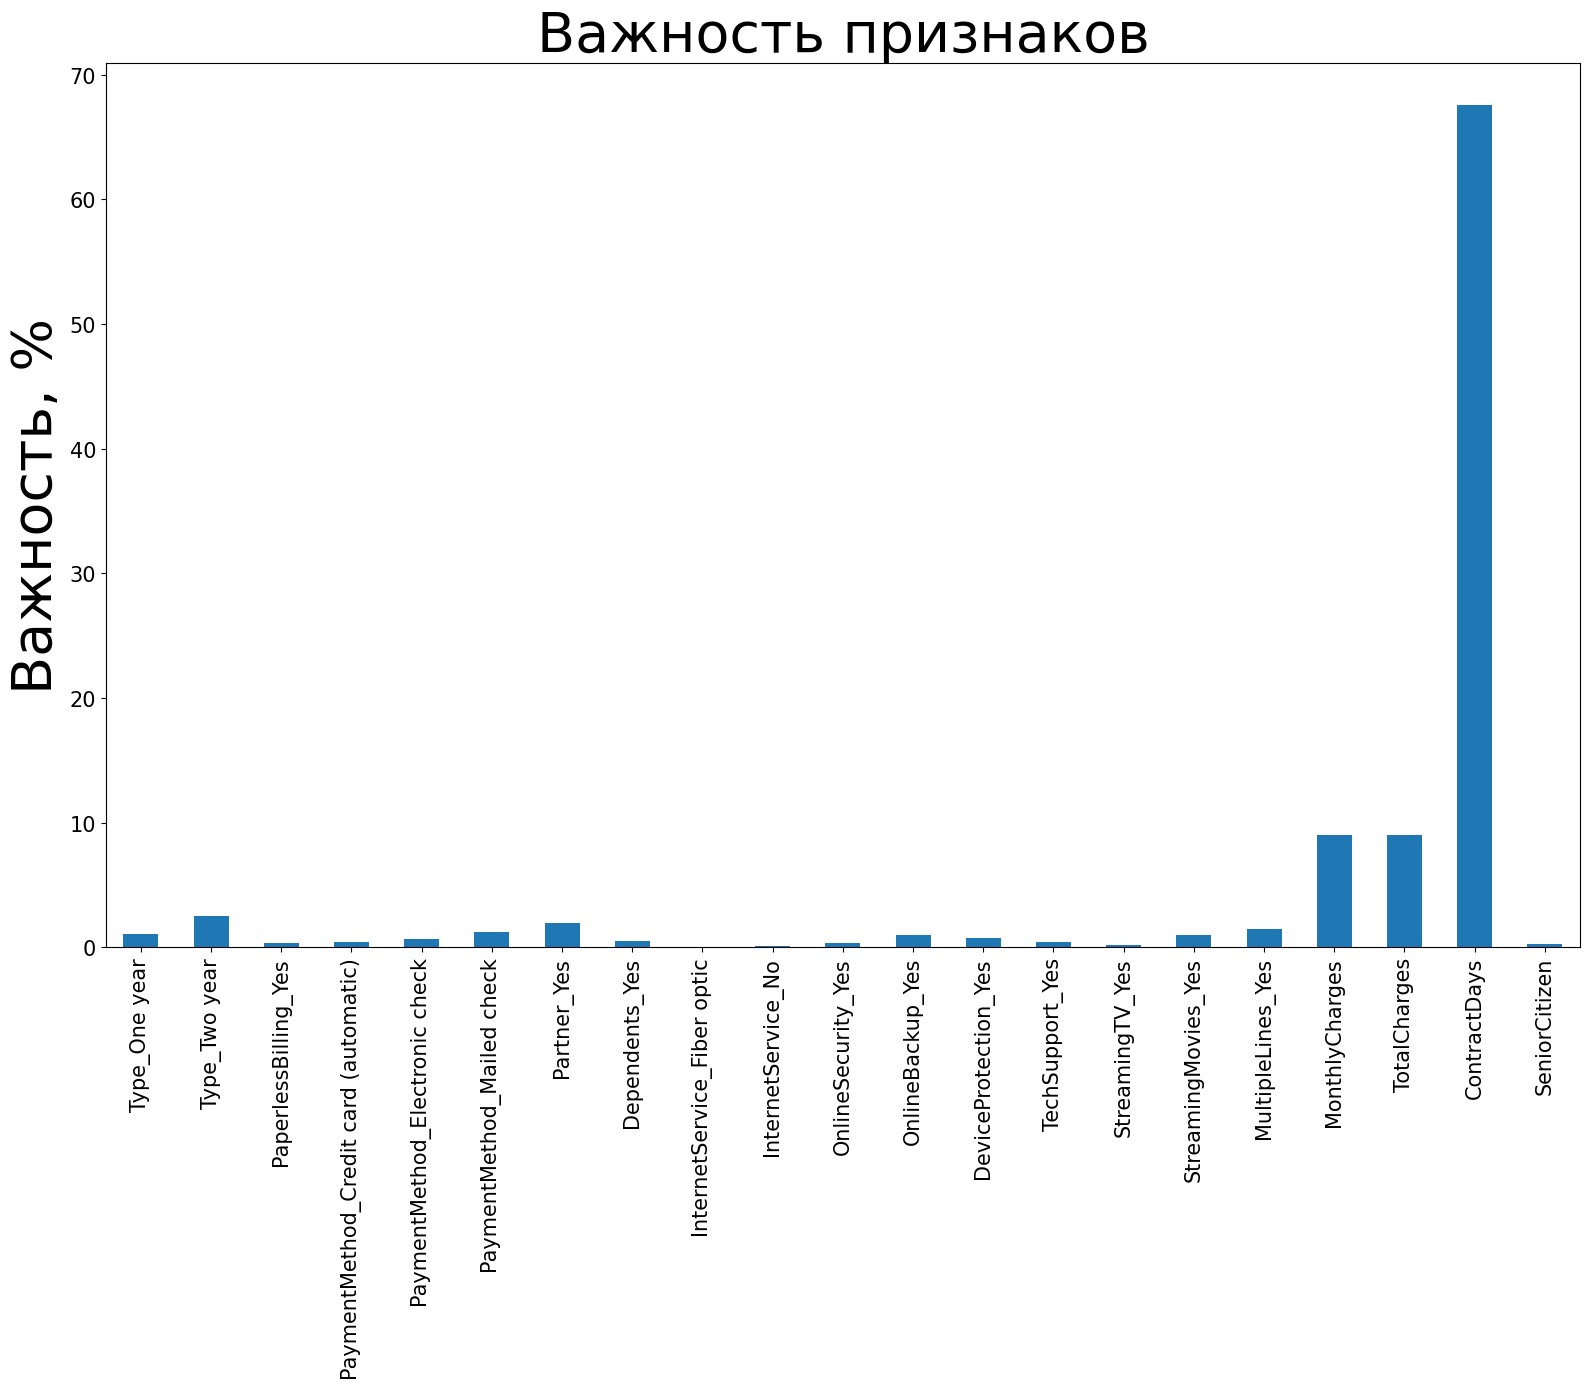

In [75]:
# строим график для оценки важности признаков
cat_imp = pd.Series(grid_cat.best_estimator_._final_estimator.feature_importances_,
                         features_train_ohe.columns)
fig, ax = plt.subplots(figsize=(16,14))
cat_imp.plot.bar(ax=ax, fontsize =15)
ax.set_title('Важность признаков', fontsize =40)
ax.set_ylabel('Важность, %', fontsize =40)
fig.tight_layout()

**На то, уйдёт пользователь или останется, больше всего влияет время пользования услугами и тип оплаты. Так же влияние имеет ежемесячная оплата и общая сумма платежа.**

**Расчёт бизнес метрики**

In [76]:
# формируем датафреймы 
result_lr = pd.DataFrame({'target': target_test,
                       'predictions': grid_lr.predict(features_test)}
                     )

result_rf = pd.DataFrame({'target': target_test,
                       'predictions': grid_rf.predict(features_test)}
                     )

result_cat = pd.DataFrame({'target': target_test,
                       'predictions': grid_cat.predict(features_test)}
                     )

In [77]:
# функция для бизнес метрики
def business_score(result):
    error_1 = ((result['target'] == 0) & (result['predictions'] == 1)).sum() / ((result['target'] == 0)).sum()
    
    error_2 = ((result['target'] == 1) & (result['predictions'] == 0)).sum() / ((result['target'] == 1)).sum()
    
    sss =  1 - (error_1 * 0.3 + error_2 * 1)
    return sss

In [78]:
business_score(result_cat)

0.6187899180227578

**Модель CatBoost превышает порог классификации равный 0,5**

##  Отчёт по проекту

- **Загрузка и обработка датасета**  
    
    
    - Предоставлено четыре датасета:
    
       
       - contract_new.csv - информация о договоре:  
            - BeginDate - дата начала пользования услугами
            - EndDate - дата окончания пользования услугами
            - Type - тип оплаты: ежемесячный, годовой и тд
            - PaperlessBilling - безналичный расчет
            - PaymentMethod - способ оплаты
            - MonthlyCharges - ежемесячные траты на услуги  
            - TotalCharges - всего потрачено денег на услуги
        - personal_new.csv — персональные данные клиента:
            - gender - пол клиента
            - SeniorCitizen - наличие пенсионного статуса по возрасту
            - Partner - наличие супруга(и)
            - Dependents - наличие иждивенцев       
        - internet_new.csv — информация об интернет-услугах:
            - InternetService - способ подключения интернета
            - OnlineSecurity - интернет-безопасность 
            - OnlineBackup - удалённое резервное копирование данных 
            - DeviceProtection - устройство защиты
            - TechSupport - техническая поддержка
            - StreamingTV - интернет-телевидение
            - StreamingMovies - потоковое мультимедиа
        - phone_new.csv — информация об услугах телефонии:
            - MultipleLines - возможность использовать несколько линий
    
    
    - В исходнос датасете contract_new.csv обнаружились пропуски в TotalCharges. Эти пропуски образовались у новых пользователей, заполнили значением первого мезяца оплаты
    
    
    - После объединения таблиц образовались пропущенные значения у пользователей , у которых не подключенно одновременно интернет услуги и телефония. Такого рода пропуски заполнялись значением "No", что и означает отсутствие подключенной услуги у клиента.
    
    
    - По столбцу EndDate создавался целевой признак. Если была дата окончания пользованиями услугами - значит целевая переменныя принимает значение равной "1". Для оставшихся клиентов целевая переменная равно "0".
    
    
    - Для оставшихся клиентов EndDate заполнялся датой выгрузки датасетов "2020-02-01"
    
    
    - Сформирован новый признак ContractDays - продолжительность пользования услугами в днях.
    
    
    - random_state = 80523
    
    
- **Иследование данных**

    - Построены и исследованна тепловая карта мультиколлинеарности. Выделенны признаки с нулевой и высокой корреляцией.
     
     
    - Исследованы паттерны пользователей. Построены графики отличий в распределении признаков для ушедших и оставшихся клиентов.

- **Обработка данных**


    - Выделение целевого признаки.
    
    
    - Удаление из признаков "target", "BeginDate","EndDate", "gender"
    
    
    - Разделение датасета на тренировочную и тестируемую выборки в пропорции 3 к 1. Размер тесловой выборки равен 25%
    
    
    - Подготовка макета  на основе make_column_transformer для кодирования категориальных признаков с помощью OneHotEncoder и масштабирования числительных признаков с помощью StandardScaler
    

- **Обучение моделей**


    - LogisticRegression
        - Построен конвеер make_pipeline
        - Перебор гиппер параметров осуществлялся с помощью GridSearchCV
        - Лучшие гипперпараметры:
            - C': 100
            - class_weight': 'None'
            - 1_ratio': 0.25
            - penalty': 'elasticnet'
            
            
    - RandomForestRegressor
        - Построен конвеер make_pipeline
        - Перебор гиппер параметров осуществлялся с помощью RandomizedSearchCV
        - Лучшие гипперпараметры:
            - n_estimators': 300
            - min_samples_split': 2
            - min_samples_leaf': 4
            - max_depth': 11
            - class_weight': 'balanced_subsample'
            
            
    - CatBoostClassifier
        - Построен конвеер make_pipeline
        - Перебор гиппер параметров осуществлялся с помощью RandomizedSearchCV
        - Лучшие гипперпараметры:
            - auto_class_weights': 'None'
            - depth': 2
            - learning_rate': 0.3
            
            
    - Метрики моделей на кроссвалидации
        
|          Model         |  time  | accuracy_score | roc_auc_score |
| ---------------------- | ------ |--------------- |-------------- |
| LogisticRegression     | 10.7 s |    0.712233    |   0.774717    |
| RandomForestRegressor  | 10.7 s |    0.820144    |   0.831085    |
|   СatBoostClassifier   |  8min  |    0.936197    |   0.934893    |

- **Тестирование модели**


    - На тестирование была взята лучная модель по метрике roc_auc - СatBoostClassifier
    
    
    - По результатам тестирования, модели СatBoostClassifier удалось достичь значение метрики roc_auc в 0.917899 единиц, что удовлетворяет условию проекта
    
    
    - Исследование важности признаков показало на то, что уйдёт пользователь или останется, больше всего влияет время пользования услугами и тип оплаты. Так же влияние имеет ежемесячная оплата и общая сумма платежа.
    
    
- **Ход работы**


    - Отличий от исходного плана работ не было
    
    - Все этапы были важны
    
    - Преодолённые трудности в работе - трудностей не возникло
